## LSTM with average trajectories from the dataset

In [1]:
import numpy as np
from scipy.interpolate import interp1d
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import math
import random

def pad(data):
    """
    pad data with np.nan (for data that is a list of arrays of different sizes).
    """
    
    x = len(data)
    y = max(len(arr) for arr in data)
    padded_data = np.full((x, y), np.nan)
    for i in range(x):
        padded_data[i, :len(data[i])] = data[i]
    return padded_data

def pad_2(data):
    """
    Pad a list of 2-column arrays (shape = [L_i, 2]) with np.nan 
    so they become a single array of shape (N, max_len, 2).
    """
    N = len(data)
    max_len = max(arr.shape[0] for arr in data)   # longest trajectory
    D = data[0].shape[1]                          # should be 2
    
    padded_data = np.full((N, max_len, D), np.nan)
    
    for i, arr in enumerate(data):
        length = arr.shape[0]
        padded_data[i, :length, :] = arr
    
    return padded_data

def contribution_threshold(data, cutoff_fraction):
    """
    Find the time index where certain fraction of the trajectories contribute.
    Basically, some random walkers will get stuck at a site for a long time and overshoot t_max
    by a lot. So time points will only have a few trajectories contributing to the ensemble average, 
    making it not a good statistical average/too small of a sample size.
    """
    data_arr = np.array(data)
    n_trajectories = data_arr.shape[0]
    min_required = int(cutoff_fraction * n_trajectories)  
    valid_counts = np.sum(~np.isnan(data), axis=0)
    cutoff_idx = np.where(valid_counts < min_required)[0]
    if len(cutoff_idx) > 0:
        last_valid_idx = cutoff_idx[0]
    else:
        last_valid_idx = data_arr.shape[1]
        
    return last_valid_idx


def average_trajectories(trajectories, t_max):
    """
    Carefully calculate averages of different variables over different random walkers 
    and different lattice configurations. 
    This is nontrivial since each random walker hops at different time points.
    """
    
    all_squared_displacements = [traj['sq_disp'] for traj in trajectories]
    all_times = [traj['times'] for traj in trajectories]
    all_distinct_sites = [traj['distinct_sites'] for traj in trajectories]

    #MSD vs steps
    padded_disp = pad(all_squared_displacements)
    msd_vs_steps = np.nanmean(padded_disp, axis=0)
    last_valid_idx = contribution_threshold(padded_disp, 0.8)
    msd_vs_steps = msd_vs_steps[:last_valid_idx]

    #MSD vs time
    from scipy.interpolate import interp1d

    t_bins = np.linspace(0, t_max, last_valid_idx)
    all_interp_disp = []
    for times, sq_disp in zip(all_times, all_squared_displacements):
        times = np.array(times)
        sq_disp = np.array(sq_disp)
        valid_mask = times <= t_max
        f = interp1d(times[valid_mask], sq_disp[valid_mask],
                     kind='previous', bounds_error=False, fill_value=np.nan)
        interp_disp = f(t_bins)
        all_interp_disp.append(interp_disp)

    msd_vs_time = np.nanmean(all_interp_disp, axis=0)
    last_valid_idx_time = contribution_threshold(all_interp_disp, 0.8)
    t_bins = t_bins[:last_valid_idx_time]
    msd_vs_time = msd_vs_time[:last_valid_idx_time]

    #Distinct sites visited vs steps
    padded_distinct_sites = pad(all_distinct_sites)
    distinct_sites_vs_steps = np.nanmean(padded_distinct_sites, axis=0)
    last_valid_idx_sites = contribution_threshold(padded_distinct_sites, 0.8)
    distinct_sites_vs_steps = distinct_sites_vs_steps[:last_valid_idx_sites]

    return msd_vs_steps, msd_vs_time, t_bins, distinct_sites_vs_steps




In [2]:
def build_features_for_trajectory(trajectories, t_max, seq_len, add_derivative=False):
    """
    Return features shape (seq_len, n_features) for one trajectory.
    Features: sq_disp, distinct_sites (and optional derivative of sq_disp).
    """
    seq_sq = trajectories['sq_disp']
    seq_sites =trajectories['distinct_sites']
    features = [seq_sq, seq_sites]
    # stack features -> (seq_len, n_features)
    feat = np.vstack(features).T.astype(np.float32)
    return feat

def build_dataset_from_trajectories(trajectories, labels, t_max=150.0, seq_len=200):
    """
    trajectories: list of dicts
    labels: dict with keys 'lattice', 'p', 'longrange' each a list/array of ints aligned with trajectories
    Returns: X (N, seq_len, n_features), y1,y2,y3 (N,)
    """
    N = len(trajectories)
    y1 = np.array(labels['lattice'], dtype=np.int64)
    y2 = np.array(labels['p'], dtype=np.int64)
    y3 = np.array(labels['longrange'], dtype=np.int64)
    X = [build_features_for_trajectory(traj,t_max, seq_len) for traj in trajectories]
    return X, y1, y2, y3

In [ ]:
t_max = 150.0
seq_len = 200
trajectories = []
labels = {'lattice':[], 'conc':[], 'coupling':[]}

import os
import re
import numpy as np
import pandas as pd


data_folder = r"C:\Users\Ke\Documents\GithubRepo\Project_3_Physics188_288\Data"

pattern = re.compile(
    r"(?P<lat>BCC|diamond|FCC|SC)_p=(?P<p>\d+)%_(?P<int>alpha=6|nearestneighbor)\.npz"
)

records = []
data_list = []

for fname in os.listdir(data_folder):
    match = pattern.match(fname)
    if not match:
        print("Skipping invalid file:", fname)
        continue
    
    lattice_str = match.group("lat")
    if lattice_str == "BCC":
        lattice = 0
    elif lattice_str =="diamond":
        lattice = 1
    elif lattice_str == "FCC":
        lattice = 2
    else: # "SC"
        lattice = 3 

    p = float(match.group("p")) / 100.0
    
    longrange_str = match.group("int")

    longrange = 1 if longrange_str == "alpha=6" else 0

    file_path = os.path.join(data_folder, fname)
    data = np.load(file_path, allow_pickle=True)

    results = data['results']

    # divide the trajectories data into different block and average over each block, make sure block_size \times num_blocks = 10,000
    block_size = 100
    num_blocks = 100

    for i in range(num_blocks):
        start = i * block_size
        end = (i + 1) * block_size
        trajectories_temp = results[start:end]
        # results = data[list(data.keys())[0]]
        msd_vs_steps, msd_vs_time, t_bins, distinct_sites_vs_steps = average_trajectories(trajectories_temp, t_max)
        n_steps = np.arange(0, len(msd_vs_steps))
        # print(len(distinct_sites_vs_steps))

        trajectories.append({'steps':n_steps, 'sq_disp':msd_vs_steps, 'distinct_sites':distinct_sites_vs_steps})
        records.append({
            "filename": fname,
            "lattice": lattice,
            "p": p,
            "longrange": longrange
        })
labels = pd.DataFrame(records)



C:\Users\Ke\AppData\Local\Temp\ipykernel_3268\4278322791.py:92: RuntimeWarning: Mean of empty slice
  msd_vs_time = np.nanmean(all_interp_disp, axis=0)


Skipping invalid file: README.md
Skipping invalid file: test


# Two layers LSTM model

In [82]:
import numpy as np
import tensorflow as tf
from keras import optimizers
from keras.layers import LSTM, Dense, Dropout, Masking
from keras.models import Sequential
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input
from keras.callbacks import EarlyStopping

# Seed everything
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1' 

# ============================================================
# VARIABLE-LENGTH DATA
# ============================================================

num_samples = 3200
F = 2
num_outputs = 3     # because y.shape = (N, 3)

X_list, y1, y2, y3 = build_dataset_from_trajectories(trajectories, labels, t_max=t_max, seq_len=seq_len)
y = np.stack([y1, y2, y3], axis=1)

# ============================================================
# FEATURE-WISE MINMAX SCALING
# ============================================================

scaler = MinMaxScaler()

X_concat = np.vstack(X_list)
X_scaled = scaler.fit_transform(X_concat)

X_list_scaled = []
idx = 0
for seq in X_list:
    Ti = seq.shape[0]
    X_list_scaled.append(X_scaled[idx:idx+Ti])
    idx += Ti

# ============================================================
# PADDING
# ============================================================

max_len = max(seq.shape[0] for seq in X_list_scaled)

X_padded = pad_sequences(
    X_list_scaled,
    maxlen=max_len,
    dtype="float32",
    padding="post",
    truncating="post",
    value=0.0
)

print("Padded X:", X_padded.shape)



# ============================================================
# TRAIN / VALIDATION / TEST SPLIT
# ============================================================

y1_original = y[:, 0] # 4 Class
y2_original = y[:, 1].reshape(-1, 1) # Regression
y3_original = y[:, 2].reshape(-1, 1) # Two Class
y1_onehot = to_categorical(y1_original, num_classes=4)
y3_original = to_categorical(y3_original, num_classes=2)

# Step 1: Split into train (80%) and temp (20% for val+test)
X_train, X_temp, y1_train, y1_temp, y2_train, y2_temp, y3_train, y3_temp = train_test_split(
    X_padded, y1_onehot, y2_original, y3_original, test_size=0.2, random_state=42
)

# Step 2: Split temp into validation (10%) and test (10%)
X_val, X_test, y1_val, y1_test, y2_val, y2_test, y3_val, y3_test = train_test_split(
    X_temp, y1_temp, y2_temp, y3_temp, test_size=0.5, random_state=42
)

print(f"X_train shape: {X_train.shape}") 
print(f"y1_train shape (4 Class): {y1_train.shape}") 
print(f"y2_train shape (Regression): {y2_train.shape}") 
print(f"y3_train shape (Two Class): {y3_train.shape}")

# ============================================================
# TRAIN MODEL
# ============================================================


input_tensor = Input(shape=(max_len, F)) 
x = Masking(mask_value=0.0)(input_tensor) 
x = LSTM(64, return_sequences=True)(x) 
x = Dropout(0.3)(x) 
x = LSTM(32)(x) 


output_y1 = Dense(4, activation='softmax', name='y1_classifier')(x) 
output_y2 = Dense(1, activation='relu', name='y2_regressor')(x) 
output_y3 = Dense(2, activation='softmax', name='y3_binary')(x) 
model = Model(inputs=input_tensor, outputs=[output_y1, output_y2, output_y3])
optimizer = optimizers.Adam(learning_rate=1e-3) 
model.compile( optimizer=optimizer, 
                loss={ 'y1_classifier': 'categorical_crossentropy', 
                    'y2_regressor': 'mse', 
                    'y3_binary': 'categorical_crossentropy'          
                    },
                metrics={ 'y1_classifier': ['accuracy'], 'y2_regressor': ['mse'], 'y3_binary': ['accuracy'] } )
model.summary()
# early_stopping = EarlyStopping( monitor='val_loss', 
#                                patience=5, 
#                                restore_best_weights=True, verbose=1 ) 
history = model.fit( X_train,
                    [y1_train, y2_train, y3_train], 
                    validation_data=(X_val, [y1_val, y2_val, y3_val]), 
                    epochs=100, 
                    batch_size=64, verbose=1 )



Padded X: (3200, 236, 2)
X_train shape: (2560, 236, 2)
y1_train shape (4 Class): (2560, 4)
y2_train shape (Regression): (2560, 1)
y3_train shape (Two Class): (2560, 2)


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 236, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_12        │ (None, 236, 2)    │          0 │ input_layer_12[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_12          │ (None, 236, 2)    │          0 │ input_layer_12[0… │
│ (Masking)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_12 (Any)        │ (None, 236)       │          0 │ not_equal_12[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_20 (LSTM)      │ (None, 236, 64)   │     17,152 │ masking_12[0][0], │
│                     │                   │            │ any_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 236, 64)   │          0 │ lstm_20[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_21 (LSTM)      │ (None, 32)        │     12,416 │ dropout_8[0][0],  │
│                     │                   │            │ any_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y1_classifier       │ (None, 4)         │        132 │ lstm_21[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y2_regressor        │ (None, 1)         │         33 │ lstm_21[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y3_binary (Dense)   │ (None, 2)         │         66 │ lstm_21[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,799 (116.40 KB)

 Trainable params: 29,799 (116.40 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 2.0917 - y1_classifier_accuracy: 0.3688 - y1_classifier_loss: 1.3259 - y2_regressor_loss: 0.1721 - y2_regressor_mse: 0.1721 - y3_binary_accuracy: 0.7020 - y3_binary_loss: 0.5936 - val_loss: 1.8337 - val_y1_classifier_accuracy: 0.3500 - val_y1_classifier_loss: 1.2243 - val_y2_regressor_loss: 0.1561 - val_y2_regressor_mse: 0.1561 - val_y3_binary_accuracy: 0.8281 - val_y3_binary_loss: 0.4533
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 1.7594 - y1_classifier_accuracy: 0.5105 - y1_classifier_loss: 1.1230 - y2_regressor_loss: 0.1584 - y2_regressor_mse: 0.1584 - y3_binary_accuracy: 0.7730 - y3_binary_loss: 0.4779 - val_loss: 1.5621 - val_y1_classifier_accuracy: 0.4719 - val_y1_classifier_loss: 1.0093 - val_y2_regressor_loss: 0.1332 - val_y2_regressor_mse: 0.1332 - val_y3_binary_accuracy: 0.8406 - val_y3_binary_loss: 0.4196
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 1.4232 - y1_classifier_accuracy: 0.6

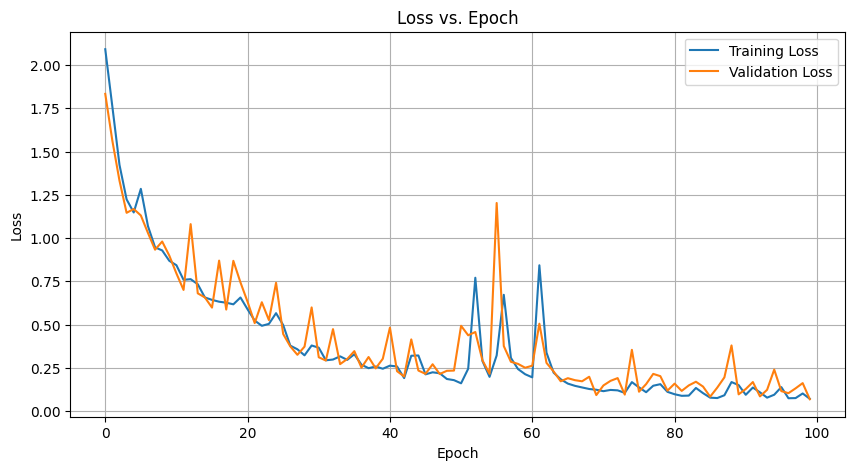

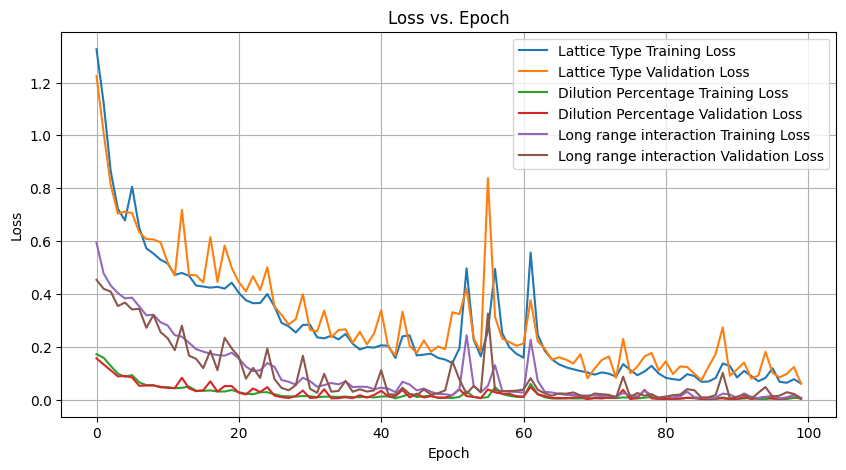

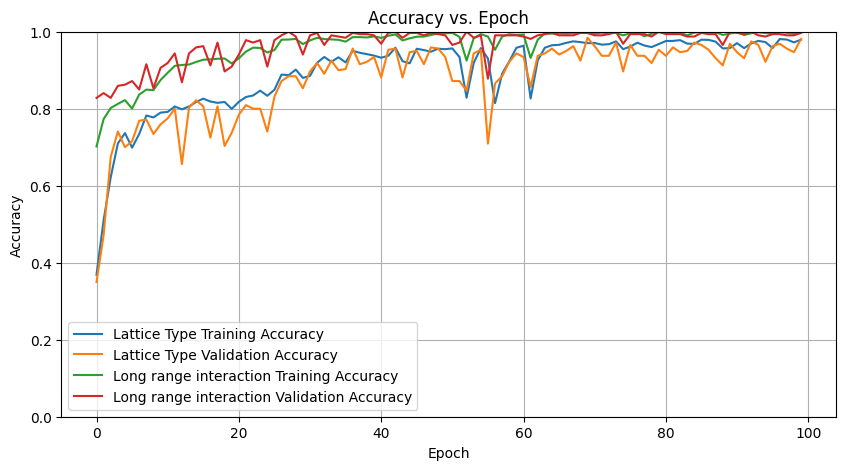

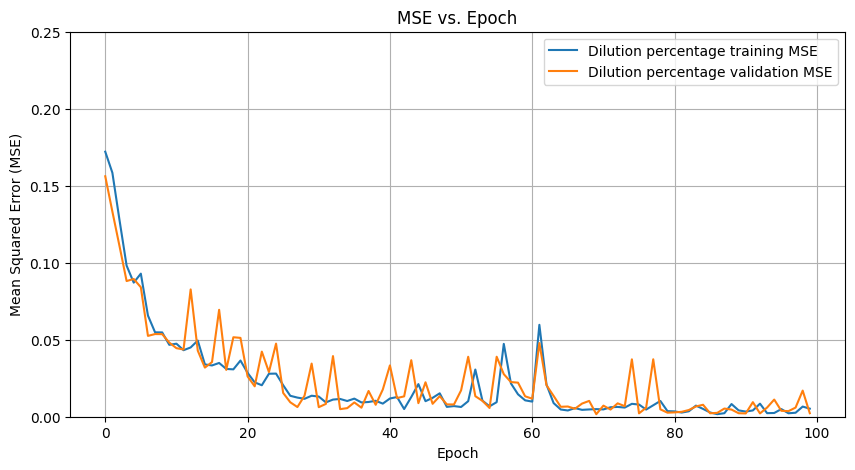


Model saved as lstm_multilabel_multiend_classifier2.h5


In [83]:
import matplotlib.pyplot as plt

# Plot ALL Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['y1_classifier_loss'], label='Lattice Type Training Loss')
plt.plot(history.history['val_y1_classifier_loss'], label='Lattice Type Validation Loss')

plt.plot(history.history['y2_regressor_loss'], label='Dilution Percentage Training Loss')
plt.plot(history.history['val_y2_regressor_loss'], label='Dilution Percentage Validation Loss')

plt.plot(history.history['y3_binary_loss'], label='Long range interaction Training Loss')
plt.plot(history.history['val_y3_binary_loss'], label='Long range interaction Validation Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['y1_classifier_accuracy'], label='Lattice Type Training Accuracy')
plt.plot(history.history['val_y1_classifier_accuracy'], label='Lattice Type Validation Accuracy')

plt.plot(history.history['y3_binary_accuracy'], label='Long range interaction Training Accuracy')
plt.plot(history.history['val_y3_binary_accuracy'], label='Long range interaction Validation Accuracy')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend()
plt.grid(True)
plt.show()


# Plot MSE 
plt.figure(figsize=(10, 5))
plt.plot(history.history['y2_regressor_mse'], label='Dilution percentage training MSE')
plt.plot(history.history['val_y2_regressor_mse'], label='Dilution percentage validation MSE')
plt.title('MSE vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.ylim([0,0.25])
plt.legend()
plt.grid(True)
plt.show()


model.save("lstm_multilabel_multiend_classifier2.h5")
np.save("scaler_minmax2.npy", scaler.data_min_)
print("\nModel saved as lstm_multilabel_multiend_classifier2.h5")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


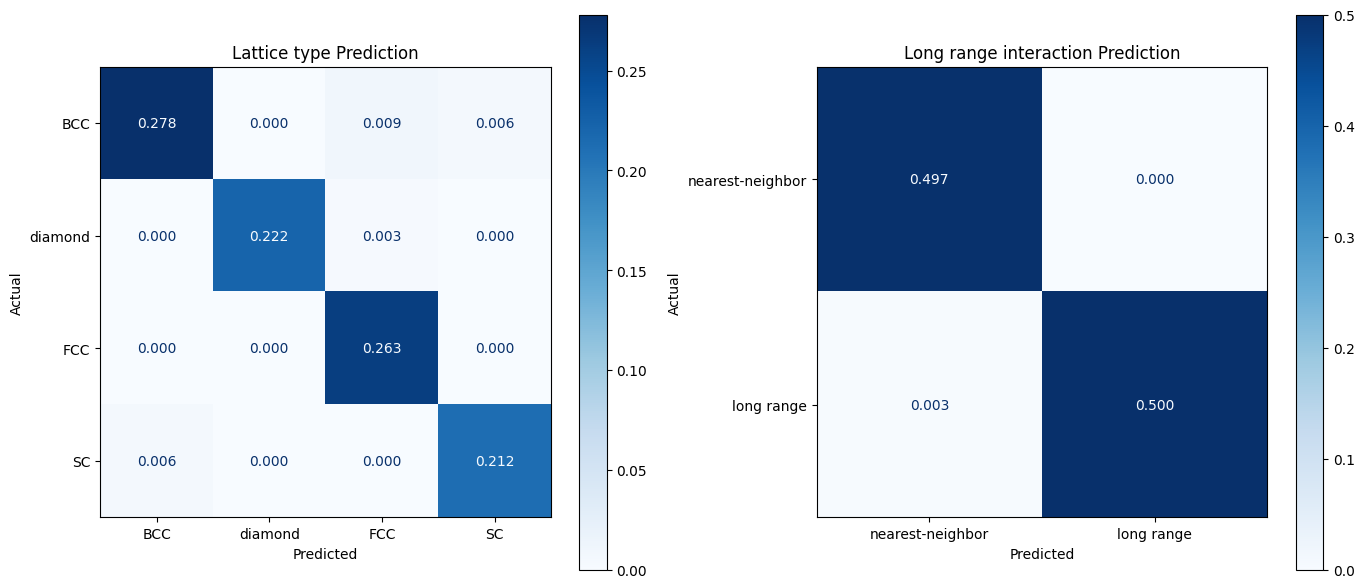

In [85]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Step 1: Split into train (80%) and temp (20% for val+test)
X_train, X_temp, y1_train, y1_temp, y2_train, y2_temp, y3_train, y3_temp = train_test_split(
    X_padded, y1_onehot, y2_original, y3_original, test_size=0.2, random_state=42
)

# Step 2: Split temp into validation (10%) and test (10%)
X_val, X_test, y1_val, y1_test, y2_val, y2_test, y3_val, y3_test = train_test_split(
    X_temp, y1_temp, y2_temp, y3_temp, test_size=0.5, random_state=42
)

y1_pred, y2_pred, y3_pred = model.predict(X_test)

# dataset: prediction and validation
y1_pred = np.argmax(y1_pred,axis=1)
y1_test = np.argmax(y1_test,axis=1)
y2_pred = np.argmax(y2_pred,axis=1)
y2_test = np.argmax(y2_test,axis=1)
y3_pred = np.argmax(y3_pred,axis=1)
y3_test = np.argmax(y3_test,axis=1)

# confusion matrices of lattice type and is_lr interaction
cm_y1 = confusion_matrix(y1_test,y1_pred)
cm_y1_num_total = cm_y1.sum()
cm_y1 = cm_y1 / cm_y1_num_total

cm_y3 = confusion_matrix(y3_test,y3_pred)
cm_y3_num_total = cm_y3.sum()
cm_y3 = cm_y3 / cm_y3_num_total

# Create figure with 1 row, 2 columns
fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # adjust width

# Left: cm_y1
disp1 = ConfusionMatrixDisplay(
    confusion_matrix=cm_y1,
    display_labels=['BCC', 'diamond', 'FCC', 'SC']
)
disp1.plot(ax=ax[0], cmap=plt.cm.Blues, values_format='.3f')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
ax[0].set_title('Lattice type Prediction')

# Right: cm_y3
disp2 = ConfusionMatrixDisplay(
    confusion_matrix=cm_y3,
    display_labels=['nearest-neighbor', 'long range']
)
disp2.plot(ax=ax[1], cmap=plt.cm.Blues, values_format='.3f')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')
ax[1].set_title('Long range interaction Prediction')

plt.tight_layout()
plt.show()


In [ ]:
y2_model = Model(inputs=model.input, outputs=model.get_layer('y2_regressor').output)

y2_model.compile(optimizer='adam', loss='mse', metrics=['mse'])

val_loss, val_mse = y2_model.evaluate(X_val, y2_val, verbose=1)
print("Val MSE for y2:", val_mse)

y2_model = Model(inputs=model.input, outputs=model.get_layer('y2_regressor').output)

y2_model.compile(optimizer='adam', loss='mse', metrics=['mse'])

test_loss, test_mse = y2_model.evaluate(X_test, y2_test, verbose=1)
print("Test MSE for y2:", test_mse)



10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0023 - mse: 0.0023   
Val MSE for y2: 0.0022722294088453054
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2160 - mse: 0.2160
Test MSE for y2: 0.2160385102033615
